### Cmpe492 Using SHAP (SHapley Additive exPlanations) for explainable Alzheimer model
#### Alper Canberk Balcı - Advisor: İnci Meliha Baytaş
- 19/11/2022 Version 1.1



In [1]:
# A bunch of libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
import seaborn as sns
import math
from sklearn import linear_model, preprocessing, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
import shap

C:\Users\Canbe\anaconda3\envs\bounAITask0\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the data

In [2]:
x_train = np.load('temporal_data.npy', allow_pickle=True)
y_train = np.load('temporal_binary_label.npy', allow_pickle=True)
x_test = np.load('test_temporal_data.npy', allow_pickle=True)
y_test = np.load('test_temporal_binary_label.npy', allow_pickle=True)


In [3]:
y_train[20]

array([1, 1, 2, 1, 4, 2, 1, 2, 1, 2, 1, 1, 4, 4, 2, 4, 2], dtype=int64)

In [4]:
# check for anomalies in the labels:
# Is there any 0 coming after becoming 1

faulty_data_counter_train = set()
for i in range(len(y_train)):
    became_alz = 0
    for j in range(len(y_train[i])):
        if y_train[i][j] in(3,5,6):
            became_alz = 1
            continue
        if became_alz == 1 and (y_train[i][j] in (1,2,4)):
            faulty_data_counter_train.add(i)


In [5]:
len(faulty_data_counter_train)

92

In [6]:
# check for anomalies in the labels:
# Is there any 0 coming after becoming 1

faulty_data_counter_test = set()
for i in range(len(y_test)):
    became_alz = 0
    for j in range(len(y_test[i])):
        if y_test[i][j] in (3,5,6):
            became_alz = 1
            continue
        if became_alz == 1 and (y_test[i][j] in (1,2,4)):
            faulty_data_counter_test.add(i)

print(len(faulty_data_counter_test))

13


In [7]:
faulty_data_counter_test

{3, 4, 7, 30, 122, 130, 189, 203, 239, 265, 280, 282, 283}

In [8]:
y_test = np.delete(y_test, list(faulty_data_counter_test), axis=0)
x_test = np.delete(x_test, list(faulty_data_counter_test), axis=0)


In [9]:
y_train = np.delete(y_train, list(faulty_data_counter_train), axis=0)
x_train = np.delete(x_train, list(faulty_data_counter_train), axis=0)

In [10]:
y_test.shape

(283,)

In [11]:
x_train.shape

(1090,)

In [12]:
x_train[0].shape
# It is now a temporal data but it will be transformed such that each time instant would be a data point.

(4, 17)

In [13]:
# Let's transform:
X_train = []
for i in range(len(x_train)):
    if i == 0:
        X_train = x_train[i]
    else:
        X_train = np.concatenate([X_train, x_train[i]])
        
Y_train = []
for i in range(len(y_train)):
    if i == 0:
        Y_train = y_train[i]
    else:
        Y_train = np.concatenate([Y_train, y_train[i]])
        
X_test = []
for i in range(len(x_test)):
    if i == 0:
        X_test = x_test[i]
    else:
        X_test = np.concatenate([X_test, x_test[i]])
        
Y_test = []
for i in range(len(y_test)):
    if i == 0:
        Y_test = y_test[i]
    else:
        Y_test = np.concatenate([Y_test, y_test[i]])

In [14]:
X_test.shape

(2133, 17)

In [15]:
X_train = pd.DataFrame(X_train, columns = ['APOE4','Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp', 'ICV'])

In [16]:
X_test = pd.DataFrame(X_test, columns = ['APOE4','Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp', 'ICV'])

### Inspect the data

In [17]:
X_train.info()
# 0:9 are cognitive test data, 10:15 are MRI data. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   APOE4        7804 non-null   float32
 1   Age          7804 non-null   float32
 2   CDRSB        7804 non-null   float32
 3   ADASI1       7804 non-null   float32
 4   ADASI3       7804 non-null   float32
 5   MMSE         7804 non-null   float32
 6   RAVLT_im     7804 non-null   float32
 7   RAVLT_leam   7804 non-null   float32
 8   RVLT_for     7804 non-null   float32
 9   FAQ          7804 non-null   float32
 10  Ventricles   7804 non-null   float32
 11  Hippocampus  7804 non-null   float32
 12  WholeBrain   7804 non-null   float32
 13  Entorhinal   7804 non-null   float32
 14  Fusiform     7804 non-null   float32
 15  Midtemp      7804 non-null   float32
 16  ICV          7804 non-null   float32
dtypes: float32(17)
memory usage: 518.4 KB


In [18]:
X_train.describe()

,APOE4,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp,ICV
count,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7.804000e+03,7804.000000,7804.000000,7804.000000,7.804000e+03
mean,0.533957,73.964073,2.007624,11.294965,17.340366,26.676704,34.875320,4.137109,4.172988,5.135315,42673.570312,6605.418457,1.008334e+06,3392.262451,16983.125000,19088.164062,1.529188e+06
std,0.659904,6.703072,2.731333,9.097569,12.284951,4.138715,14.048722,2.854974,2.591018,7.723194,24072.044922,1230.706055,1.102926e+05,813.874817,2826.461914,3246.756592,1.602587e+05
min,0.000000,55.099998,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,-12.000000,0.000000,5650.000000,2693.000000,6.490910e+05,1082.000000,7739.000000,8044.000000,7.089130e+05
25%,0.000000,70.000000,0.000000,5.000000,8.670000,25.000000,25.000000,2.000000,3.000000,0.000000,25356.750000,5774.000000,9.345142e+05,2833.750000,15110.000000,17002.000000,1.415800e+06
50%,0.000000,74.000000,1.000000,9.000000,14.000000,28.000000,34.000000,4.000000,4.000000,1.000000,37898.000000,6685.000000,1.008775e+06,3424.000000,17025.000000,19140.500000,1.519905e+06
75%,1.000000,78.500000,3.000000,15.000000,23.330000,30.000000,45.000000,6.000000,6.000000,8.000000,53936.500000,7496.000000,1.082575e+06,3973.250000,18802.750000,21360.000000,1.628568e+06
max,2.000000,91.400002,18.000000,70.000000,85.000000,30.000000,75.000000,14.000000,15.000000,30.000000,162729.000000,11207.000000,1.486040e+06,6711.000000,26280.000000,32189.000000,2.110290e+06


In [19]:
X_test.describe()

,APOE4,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp,ICV
count,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2.133000e+03,2133.000000,2133.000000,2133.000000,2.133000e+03
mean,0.474449,73.271446,1.779887,10.140187,15.803410,27.113455,36.136429,4.226911,4.206282,4.488514,42697.128906,6855.479004,1.020941e+06,3526.031982,17339.791016,19274.328125,1.540912e+06
std,0.629131,7.279107,2.455649,7.481686,10.554937,3.402801,13.055397,2.739142,2.536158,7.308755,23553.101562,1216.911499,1.102597e+05,803.575928,2701.396973,2805.256592,1.780707e+05
min,0.000000,56.200001,0.000000,0.000000,0.000000,2.000000,0.000000,-4.000000,-3.000000,0.000000,10497.000000,3552.000000,7.184870e+05,1041.000000,9019.000000,9811.000000,2.918840e+02
25%,0.000000,68.300003,0.000000,5.000000,8.330000,26.000000,27.000000,2.000000,3.000000,0.000000,26554.000000,6088.000000,9.470970e+05,2994.000000,15921.000000,17383.000000,1.415790e+06
50%,0.000000,73.199997,1.000000,8.000000,13.000000,28.000000,35.000000,4.000000,4.000000,1.000000,37559.000000,6847.000000,1.022880e+06,3548.000000,17356.000000,19452.000000,1.517100e+06
75%,1.000000,78.800003,2.500000,13.000000,20.330000,30.000000,45.000000,6.000000,6.000000,6.000000,53763.000000,7677.000000,1.092840e+06,4104.000000,19104.000000,21197.000000,1.673150e+06
max,2.000000,90.099998,17.000000,58.000000,73.000000,30.000000,75.000000,12.000000,14.000000,30.000000,150708.000000,9694.000000,1.342720e+06,6062.000000,28510.000000,29424.000000,1.995370e+06


#### v1.0
- The dataset is already prepared.
- It doesn't have any null values.
- It is normalized and all numeric. I can add two categorical features: Sex and Marital Status. Maybe later.

#### v1.1:
- HOWEVER: It is come to my realization that the scaling process done on MRI Data made the columns *such skewed* that they don't contribute to the score when training a logistic regression model.
- Thus, I will change the columns so that the skeweness (left skeweness in this case) will cease to exist or be milder.
- For that, I will try log transform and boxcox transform.
- But first lets do an anomaly detection, maybe problem comes from there

In [20]:
# ICV column min value = 2.918840e+02. Must be an anomaly as min value in X_train is more reasonable, let's check it out!

X_test_ICV = X_test['ICV']  # Creates a Series
X_test_ICV = pd.DataFrame(X_test_ICV)  # Converts it to a dataframe
sorted_ICV = X_test_ICV.sort_values(by = "ICV")
sorted_ICV[0:15]

# As we can see, row 1052 has extremely low value with respect to other values.
# I don't know if this row caused the problem in scaling the data, but I am deleting that data point.
# also deleting these 8.43*10**5 ones.

,ICV
1052,2.918840e+02
684,8.432900e+05
683,8.432900e+05
682,8.432900e+05
681,8.432900e+05
679,8.432900e+05
677,8.432900e+05
676,8.432900e+05
675,8.432900e+05
674,8.432900e+05


In [21]:
X_train_ICV = X_train['ICV']  # Creates a Series
X_train_ICV = pd.DataFrame(X_train_ICV)  # Converts it to a dataframe
sorted_ICV = X_train_ICV.sort_values(by = "ICV")
sorted_ICV[0:25]

# let's delete 7605, 3427, 3426 as well.

,ICV
7605,708913.0
3427,716133.0
3426,716133.0
2593,1139130.0
2595,1142480.0
2596,1142480.0
5522,1144750.0
6973,1147150.0
6980,1152040.0
6977,1152040.0


In [22]:
# removing the row 1052
# delete a single row
X_test = X_test.drop(labels=[1052,684,683,682,681,679,677,676,675,674], axis=0)
Y_test = np.delete(Y_test, [1052,684,683,682,681,679,677,676,675,674], axis=0)
X_test.describe()



# Nice.

,APOE4,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp,ICV
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2.123000e+03,2123.000000,2123.000000,2123.000000,2.123000e+03
mean,0.476684,73.275459,1.787565,10.162204,15.839382,27.103155,36.093266,4.227037,4.211022,4.509185,42810.500000,6855.197266,1.021952e+06,3528.200684,17344.931641,19302.193359,1.544595e+06
std,0.629766,7.294235,2.458678,7.491973,10.565002,3.407344,13.068253,2.744592,2.538252,7.319701,23550.349609,1219.767822,1.095148e+05,804.808533,2706.701904,2780.350586,1.692997e+05
min,0.000000,56.200001,0.000000,0.000000,0.000000,2.000000,0.000000,-4.000000,-3.000000,0.000000,10497.000000,3552.000000,7.184870e+05,1041.000000,9019.000000,9811.000000,1.116280e+06
25%,0.000000,68.300003,0.000000,5.000000,8.330000,26.000000,27.000000,2.000000,3.000000,0.000000,26684.000000,6083.500000,9.485745e+05,2992.000000,15921.000000,17437.500000,1.417330e+06
50%,0.000000,73.400002,1.000000,8.000000,13.000000,28.000000,35.000000,4.000000,4.000000,1.000000,37588.000000,6842.000000,1.023060e+06,3557.000000,17382.000000,19463.000000,1.518360e+06
75%,1.000000,78.900002,2.500000,13.000000,20.330000,30.000000,45.000000,6.000000,6.000000,6.000000,53889.000000,7691.000000,1.093030e+06,4108.000000,19104.000000,21206.000000,1.674675e+06
max,2.000000,90.099998,17.000000,58.000000,73.000000,30.000000,75.000000,12.000000,14.000000,30.000000,150708.000000,9694.000000,1.342720e+06,6062.000000,28510.000000,29424.000000,1.995370e+06


In [23]:
X_train = X_train.drop(labels=[7605,3427,3426], axis=0)
Y_train = np.delete(Y_train, [7605,3427,3426], axis=0)
X_train.describe()


,APOE4,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp,ICV
count,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7.801000e+03,7801.000000,7801.000000,7801.000000,7.801000e+03
mean,0.533906,73.964233,2.008076,11.297129,17.343830,26.675940,34.869247,4.135367,4.172286,5.137034,42677.128906,6605.432129,1.008393e+06,3392.327148,16983.845703,19089.035156,1.529501e+06
std,0.659961,6.704332,2.731757,9.098573,12.285956,4.139286,14.047961,2.853901,2.590675,7.724175,24075.863281,1230.936523,1.102704e+05,814.013794,2826.593262,3246.573242,1.594894e+05
min,0.000000,55.099998,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,-12.000000,0.000000,5650.000000,2693.000000,6.490910e+05,1082.000000,7739.000000,8044.000000,1.139130e+06
25%,0.000000,70.000000,0.000000,5.000000,8.670000,25.000000,25.000000,2.000000,3.000000,0.000000,25353.000000,5774.000000,9.348290e+05,2833.000000,15110.000000,17004.000000,1.415880e+06
50%,0.000000,74.000000,1.000000,9.000000,14.000000,28.000000,34.000000,4.000000,4.000000,1.000000,37907.000000,6685.000000,1.008840e+06,3424.000000,17025.000000,19143.000000,1.519960e+06
75%,1.000000,78.500000,3.000000,15.000000,23.330000,30.000000,45.000000,6.000000,6.000000,8.000000,53938.000000,7496.000000,1.082620e+06,3974.000000,18805.000000,21363.000000,1.628650e+06
max,2.000000,91.400002,18.000000,70.000000,85.000000,30.000000,75.000000,14.000000,15.000000,30.000000,162729.000000,11207.000000,1.486040e+06,6711.000000,26280.000000,32189.000000,2.110290e+06


### Scaling the Data
- https://surfer.nmr.mgh.harvard.edu/fswiki/eTIV 
- https://www.frontiersin.org/articles/10.3389/fnagi.2014.00264/full
- https://www.researchgate.net/publication/11787474_Normalization_of_cerebral_volumes_by_use_of_intracranial_volume_Implications_for_longitudinal_quantitative_MR_imaging
- We have to take ICV into account when scaling the MRI data as people have different brain sizes in the first place.


In [24]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
# A basic scaling is not suited well MRI data. Sources are above.


In [25]:
# ICV normalizing the data:
X_train['Ventricles'] = X_train['Ventricles']/X_train['ICV']
X_train['Hippocampus'] = X_train['Hippocampus']/X_train['ICV']
X_train['WholeBrain'] = X_train['WholeBrain']/X_train['ICV']
X_train['Entorhinal'] = X_train['Entorhinal']/X_train['ICV']
X_train['Fusiform'] = X_train['Fusiform']/X_train['ICV']
X_train['Midtemp'] = X_train['Midtemp']/X_train['ICV']

X_test['Ventricles'] = X_test['Ventricles']/X_test['ICV']
X_test['Hippocampus'] = X_test['Hippocampus']/X_test['ICV']
X_test['WholeBrain'] = X_test['WholeBrain']/X_test['ICV']
X_test['Entorhinal'] = X_test['Entorhinal']/X_test['ICV']
X_test['Fusiform'] = X_test['Fusiform']/X_test['ICV']
X_test['Midtemp'] = X_test['Midtemp']/X_test['ICV']

In [26]:
X_test.describe()

,APOE4,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp,ICV
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2.123000e+03
mean,0.476684,73.275459,1.787565,10.162204,15.839382,27.103155,36.093266,4.227037,4.211022,4.509185,0.027164,0.004470,0.663912,0.002295,0.011288,0.012561,1.544595e+06
std,0.629766,7.294235,2.458678,7.491973,10.565002,3.407344,13.068253,2.744592,2.538252,7.319701,0.013211,0.000828,0.053451,0.000512,0.001690,0.001754,1.692997e+05
min,0.000000,56.200001,0.000000,0.000000,0.000000,2.000000,0.000000,-4.000000,-3.000000,0.000000,0.006795,0.002249,0.524934,0.000863,0.005868,0.007182,1.116280e+06
25%,0.000000,68.300003,0.000000,5.000000,8.330000,26.000000,27.000000,2.000000,3.000000,0.000000,0.018064,0.003892,0.624738,0.001989,0.010172,0.011533,1.417330e+06
50%,0.000000,73.400002,1.000000,8.000000,13.000000,28.000000,35.000000,4.000000,4.000000,1.000000,0.024937,0.004499,0.663554,0.002345,0.011345,0.012584,1.518360e+06
75%,1.000000,78.900002,2.500000,13.000000,20.330000,30.000000,45.000000,6.000000,6.000000,6.000000,0.033265,0.005032,0.702234,0.002654,0.012524,0.013746,1.674675e+06
max,2.000000,90.099998,17.000000,58.000000,73.000000,30.000000,75.000000,12.000000,14.000000,30.000000,0.084856,0.006780,0.809191,0.003841,0.016470,0.018511,1.995370e+06


In [27]:
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
# transforms dataframes to numpy, gotta convert back

In [28]:
X_test = pd.DataFrame(X_test, columns = ['APOE4','Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp', 'ICV']) 
X_train = pd.DataFrame(X_train, columns = ['APOE4','Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp', 'ICV']) 

In [29]:
X_test.describe()

,APOE4,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp,ICV
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000
mean,0.238342,0.503701,0.105151,0.175210,0.216978,0.896541,0.481244,0.514190,0.424178,0.150306,0.260938,0.490191,0.488918,0.481101,0.511222,0.474814,0.487225
std,0.314883,0.215169,0.144628,0.129172,0.144726,0.121691,0.174243,0.171537,0.149309,0.243990,0.169244,0.182622,0.188040,0.171934,0.159421,0.154853,0.192585
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.356932,0.000000,0.086207,0.114110,0.857143,0.360000,0.375000,0.352941,0.000000,0.144357,0.362632,0.351107,0.378282,0.405943,0.384058,0.342456
50%,0.000000,0.507375,0.058824,0.137931,0.178082,0.928571,0.466667,0.500000,0.411765,0.033333,0.232406,0.496491,0.487659,0.497724,0.516619,0.476835,0.457382
75%,0.500000,0.669617,0.147059,0.224138,0.278493,1.000000,0.600000,0.625000,0.529412,0.200000,0.339090,0.614191,0.623732,0.601336,0.627843,0.579423,0.635197
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
X_train.describe()

,APOE4,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp,ICV
count,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000
mean,0.266953,0.519676,0.111560,0.161388,0.204045,0.889198,0.464923,0.480809,0.598974,0.171234,0.273837,0.449839,0.509211,0.403425,0.489632,0.537807,0.401964
std,0.329981,0.184692,0.151764,0.129980,0.144541,0.137976,0.187306,0.150205,0.095951,0.257473,0.164933,0.160626,0.151942,0.132720,0.147591,0.149792,0.164226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.410468,0.000000,0.071429,0.102000,0.833333,0.333333,0.368421,0.555556,0.000000,0.152574,0.332139,0.397042,0.315035,0.390970,0.443890,0.284968
50%,0.000000,0.520661,0.055556,0.128571,0.164706,0.933333,0.453333,0.473684,0.592593,0.033333,0.246474,0.451569,0.514065,0.412977,0.489225,0.545500,0.392139
75%,0.500000,0.644628,0.166667,0.214286,0.274471,1.000000,0.600000,0.578947,0.666667,0.266667,0.360235,0.562264,0.612823,0.492460,0.591956,0.642755,0.504057
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### My comments on column statistics

- CDRSB, ADASI1, ADASI3, MMSE, FAQ, Ventricles columns' distributions are skewed. Not like a normal distribution.
- in some MRI data columns, from the quantiles and mean statistic, we can deduce that, train and test data distributions are not the same for those columns.
- For now we don't need log transform etc. Let's get to the modeling.

#### 1. Log-Transform trial (No need I guess, for now, ignore)

In [ ]:
# log_distr_x_train = np.log(X_train + 10**-10)

In [12]:
# boxcox
#from scipy import stats
#from sklearn.preprocessing import MinMaxScaler

### Fit a linear logistic regression model

In [31]:
Y_test_describe = pd.DataFrame(Y_test)
Y_train_describe = pd.DataFrame(Y_train)

In [32]:
Y_test_describe.value_counts()

2    923
1    759
3    367
5     52
4     22
dtype: int64

In [33]:
Y_train_describe.value_counts()

2    3226
1    2722
3    1508
5     248
4      95
6       2
dtype: int64

In [34]:
# Adjusting to binary classification:

Y_train[Y_train == 1] = 0
Y_train[Y_train == 2] = 0
Y_train[Y_train == 4] = 0
Y_train[Y_train == 3] = 1
Y_train[Y_train == 5] = 1
Y_train[Y_train == 6] = 1

Y_test[Y_test == 1] = 0
Y_test[Y_test == 2] = 0
Y_test[Y_test == 4] = 0
Y_test[Y_test == 3] = 1
Y_test[Y_test == 5] = 1
Y_test[Y_test == 6] = 1

In [35]:
Y_test_describe = pd.DataFrame(Y_test)
Y_train_describe = pd.DataFrame(Y_train)

In [36]:
Y_test_describe.value_counts()

0    1704
1     419
dtype: int64

In [37]:
Y_train_describe.value_counts()

0    6043
1    1758
dtype: int64

In [38]:
logmodel = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")

In [39]:
logmodel.fit(X_train, Y_train)

LogisticRegression(max_iter=2000, penalty='l1', solver='saga', tol=0.001)

In [40]:
predictions = logmodel.predict(X_test)

In [41]:
predictions.sum()

404

In [42]:
score = logmodel.score(X_test,Y_test)
score

0.945831370701837

### Statistics regarding the predictions

In [43]:
precision_recall_fscore_support(Y_test, predictions)
# Return value may look cryptic.
# Precision: 0.87623762
# Recall   : 0.84486874

(array([0.96218732, 0.87623762]),
 array([0.97065728, 0.84486874]),
 array([0.96640374, 0.86026731]),
 array([1704,  419], dtype=int64))

In [44]:
cm = confusion_matrix(Y_test, predictions)

In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

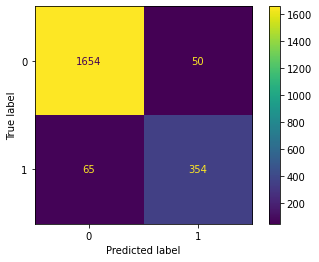

In [46]:
disp.plot()

### Explain the model and features using SHAP
 https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html
 
https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html#shap.Explainer

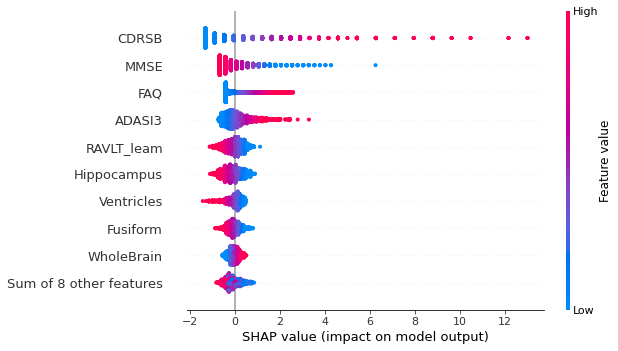

In [47]:
explainer = shap.Explainer(logmodel, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

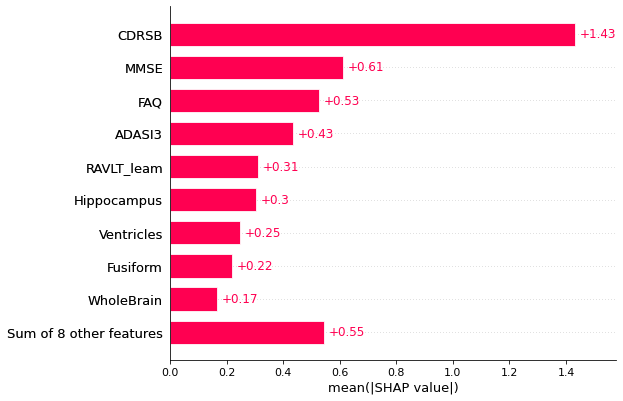

In [48]:
shap.plots.bar(shap_values)

In [49]:
shap.initjs()

In [50]:
ind = 16
shap.plots.force(shap_values[ind])

### XGBoost Trial

I want to try xgboost model as well. It is prone to overfitting, less easily interpreted. Trying it with SHAP may give some insight about modeling.

In [51]:
import xgboost as xgb

In [52]:
clf_xgb2 = xgb.XGBClassifier(objective='binary:logistic',
                            booster="gbtree",
                            seed=11,
                            #num_class=2,
                            eta=0.154,
                            #gamma=0.25,
                            max_depth=16,
                            #min_child_weight=0.07,
                            #subsample=0.81,
                            reg_lambda=0.012,
                            #reg_alpha = 0.0009,
                            #max_bin = 650,
                            num_parallel_tree=5,
                            normalize_type="forest",
                            # tree_method = "hist",
                            # colsample_bytree=0.4,
                            eval_metric='rmse', #rmsle for outliers.
                            early_stopping_rounds = 10)
# sample_type = weighted , normalize_type = forest, rate_drop 0-1, ============ booster=dart
# colsample_bytree, colsample_bylevel, colsample_bynode 

clf_xgb2.fit(X_train,
            Y_train,
            # sample_weight=sample_weights,
            verbose=True,
            eval_set=[(X_test, Y_test)])


[00:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "normalize_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:0.44086
[1]	validation_0-rmse:0.39142
[2]	validation_0-rmse:0.35279
[3]	validation_0-rmse:0.32120
[4]	validation_0-rmse:0.29666
[5]	validation_0-rmse:0.27679
[6]	validation_0-rmse:0.26319
[7]	validation_0-rmse:0.25178
[8]	validation_0-rmse:0.24208
[9]	validation_0-rmse:0.23325
[10]	validation_0-rmse:0.22612
[11]	validation_0-rmse:0.22152
[12]	validation_0-rmse:0.21777
[13]	validation_0-rmse:0.21498
[14]	validation_0-rmse:0.21360
[15]	validation_0-rmse:0.21192
[16]	validation_0-rmse:0.20987
[17]	validation_0-rmse:0.20804
[18]	validation_0-rmse:0.2078

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False, eta=0.154,
              eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.153999999, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=16, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, normalize_type='forest', num_parallel_tree=5,
              predictor='auto', random_state=11, ...)

In [53]:
predict_XG = clf_xgb2.predict(X_test)

In [54]:
precision_recall_fscore_support(Y_test, predict_XG)
# Precision: 0.83840749
# Recall   : 0.85441527

(array([0.96403302, 0.83840749]),
 array([0.95950704, 0.85441527]),
 array([0.96176471, 0.8463357 ]),
 array([1704,  419], dtype=int64))

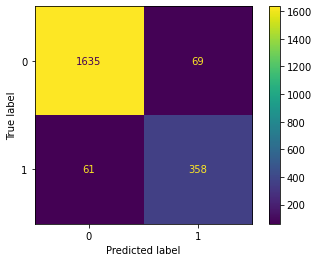

In [55]:
cm = confusion_matrix(Y_test, predict_XG)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


- XGBoost precision and recall is somewhat comparable with the logistic regression, after significant amount of hyperparameter tuning. More effort should be put in while working on the neural network model.
- Now try the SHAP for xgboost.





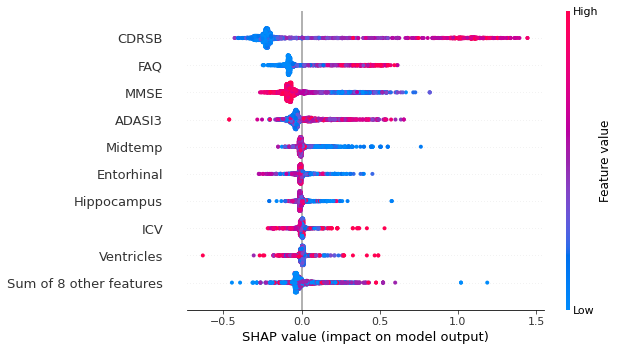

In [56]:
explainer = shap.TreeExplainer(clf_xgb2, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)
# It gives different SHAP values. They look like swords, where for logistic regression they were looking like footballs.
# https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap/notebook

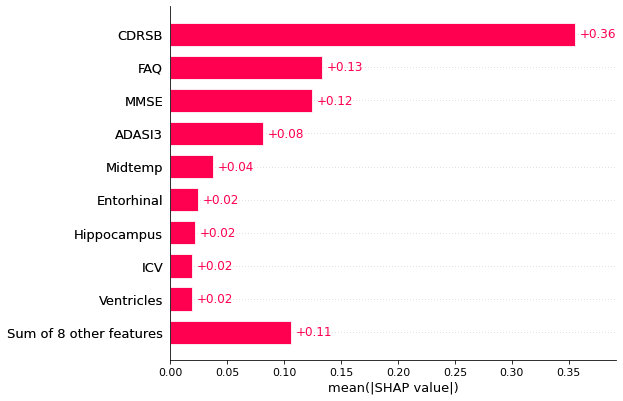

In [57]:
shap.plots.bar(shap_values)

In [58]:
shap.initjs()
ind = 16
shap.plots.force(shap_values[ind])

- For now, I delay another model, especially non-linear, deep models. 
- Let's focus on the features.
- Divide the features into two and train with each alone. Cognitive ones, MRI ones.

### Cognitive features alone

In [59]:
X_train_cogn = pd.DataFrame(X_train, columns = ['Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ'])
X_test_cogn = pd.DataFrame(X_test, columns = ['Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ'])

In [60]:
X_train_cogn.describe()

,Age,CDRSB,ADASI1,ADASI3,MMSE,RAVLT_im,RAVLT_leam,RVLT_for,FAQ
count,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000
mean,0.519676,0.111560,0.161388,0.204045,0.889198,0.464923,0.480809,0.598974,0.171234
std,0.184692,0.151764,0.129980,0.144541,0.137976,0.187306,0.150205,0.095951,0.257473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.410468,0.000000,0.071429,0.102000,0.833333,0.333333,0.368421,0.555556,0.000000
50%,0.520661,0.055556,0.128571,0.164706,0.933333,0.453333,0.473684,0.592593,0.033333
75%,0.644628,0.166667,0.214286,0.274471,1.000000,0.600000,0.578947,0.666667,0.266667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
logmodel = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")
logmodel.fit(X_train_cogn, Y_train)
predictions = logmodel.predict(X_test_cogn)

In [62]:
score = logmodel.score(X_test_cogn,Y_test)
score # same score with all features

0.9477154969382948

In [63]:
precision_recall_fscore_support(Y_test, predictions)  # same score with all features

(array([0.96497373, 0.87560976]),
 array([0.97007042, 0.85680191]),
 array([0.96751536, 0.86610374]),
 array([1704,  419], dtype=int64))

### Explain the model and *cognitive* features using SHAP

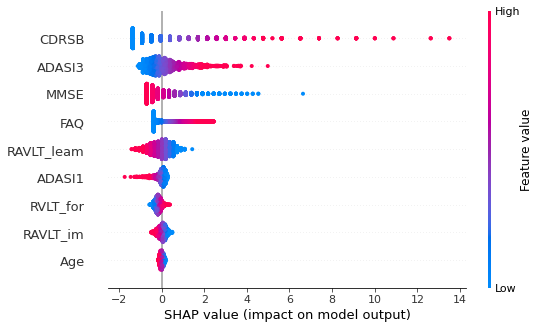

In [64]:
explainer = shap.Explainer(logmodel, X_train_cogn)
shap_values = explainer(X_test_cogn)
shap.plots.beeswarm(shap_values)

### MRI features alone

In [65]:
X_train_MRI = pd.DataFrame(X_train, columns = ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp'])
X_test_MRI = pd.DataFrame(X_test, columns = ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp'])

In [66]:
X_train_MRI.describe()

,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,Midtemp
count,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000
mean,0.273837,0.449839,0.509211,0.403425,0.489632,0.537807
std,0.164933,0.160626,0.151942,0.132720,0.147591,0.149792
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.152574,0.332139,0.397042,0.315035,0.390970,0.443890
50%,0.246474,0.451569,0.514065,0.412977,0.489225,0.545500
75%,0.360235,0.562264,0.612823,0.492460,0.591956,0.642755
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
logmodel = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")
logmodel.fit(X_train_MRI, Y_train)
predictions = logmodel.predict(X_test_MRI)

In [68]:
score = logmodel.score(X_test_MRI,Y_test)
score # worse

0.8294865756005653

In [69]:
precision_recall_fscore_support(Y_test, predictions, zero_division=0)  # Low recall

(array([0.87112832, 0.59047619]),
 array([0.92429577, 0.44391408]),
 array([0.89692483, 0.50681199]),
 array([1704,  419], dtype=int64))

- With only MRI features,

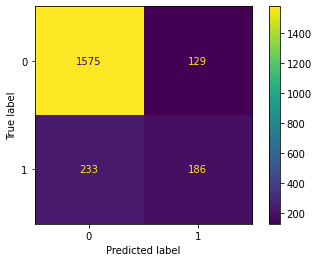

In [70]:
cm = confusion_matrix(Y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Explain the model and *MRI* features using SHAP

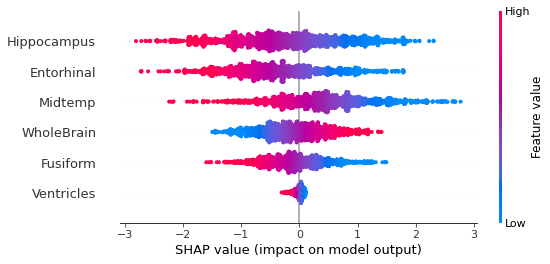

In [72]:
explainer = shap.Explainer(logmodel, X_train_MRI)
shap_values = explainer(X_test_MRI)
shap.plots.beeswarm(shap_values)

- Too many false negatives. Low recall.
- At least they work now...

### KMeans Interclass and Intraclass categories 